In this notebook I will try to develop some tools to identify candlestick patterns. Ultimately I hope to use these tools to develop trading signals (or conversely to show that candlestick patterns don't 
contain any useful information).
I will try 3 methods to see which works best:

1. Neural network using normalized prices as the input.
2. An ensemble model gradient boosted decision trees and features derived from the neural network.
3. Gradient boosted decision trees with features based on price combinations.

# Introduction

[*Candlestick charts*](https://en.wikipedia.org/wiki/Candlestick_chart) are a concise way of representing financial timeseries. For each period (usually a day) in the chart we plot a *candle* that encodes the daily open and closing prices as well as the range of prices observed in that period.

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly
plotly.offline.init_notebook_mode(connected=True) 

import keras.backend as K
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
    
import xgboost as xgb
from xgboost import XGBClassifier

import pickle

import seaborn as sns; sns.set()


In [35]:
# a function for plotting candlestick patterns
def plot_candles(candles, title='', annotation_list=[]):
  n_candles = candles.shape[0]

  if candles.shape[1] == 4: # if there is no time column
    candles = np.concatenate((np.array(range(n_candles)).reshape(n_candles,1),candles),axis=1)
  
  ann_y_offset =(max(candles[:,2])-min(candles[:,3]))*0.1
  annotations = []
  for i, ann in enumerate(annotation_list):
    if ann != 'DEF' and ann!='':
      annotations.append(go.layout.Annotation(x=i,
                                          y=candles[i,2]+ann_y_offset,
                                          showarrow=False,
                                          arrowhead=1,
                                          arrowcolor="black",
                                          arrowsize=.5,
                                          arrowwidth=.5,
                                          text=ann,
                                          textangle=90))
      
  fig = go.Figure(data=[go.Candlestick(x=candles[:,0],open=candles[:,1],high=candles[:,2],low=candles[:,3],close=candles[:,4],
                                        increasing_fillcolor= 'white', decreasing_fillcolor= 'black',
                                        increasing_line_color= 'black', decreasing_line_color= 'black',)])
    
  fig.update_layout(xaxis_rangeslider_visible=False,width = 800, height=450, margin = {'l':50,'r':50,'t':50,'b':25})
  fig.update_layout(title = title,annotations=annotations)
  fig.show()  

sample_candle = np.array([[100,105,98,103.5]])
plot_candles(sample_candle, title='Sample  candle', annotation_list=[]);



Above we see an example. The thin vertical line (referred to as the *shadow*) represents the trading range. The top and bottom of the shadow repesent the highest and lowest prices observed over the period.

The solid area in the middle (called the *body*) represents the opening and closing prices. The colour of the candle tells us whether the opening price is higher or lower than the close - a white candle if the open is higher and black if it is lower. So for example, for a white candle, the top of the body is the opening price and the bottom is the close.

Thus, candlestick charts are a useful visualization tool for any timeseries for which we know the daily opening, high, low and closing (*OHLC*) prices.

(Note that many financial instruments trade on exchanges with fixed trading hours so the closing price of one period does not necessarily coincide with the open price of the next period).

In [36]:
# Define a function to create daily price candles. We need a daily high, low, open and close.
# Note: we assume that the price evolves continously over a full 24 hour period but that it can only
# be observed during trading hours from 8 am to 5 pm

daily_vol = 0.001
steps_per_day = 24*12 # 5 minute steps
no_candles = 100
open_step = 8 * 12 -1# 8 am open
close_step = 17 * 12 -1# 5 pm close
def generate_candles(no_candles, steps_per_day, open_step, close_step, daily_vol, daily_return=0):
  total_steps = no_candles * steps_per_day
  innovations = np.random.normal(0,daily_vol/np.sqrt(steps_per_day),size=[total_steps,1])
  timeseries =  100 * np.exp(np.cumsum(innovations))
  candles = np.zeros([no_candles,5])
  for i in range(no_candles):
    full_daily_ts = timeseries[i*steps_per_day:(i+1)*steps_per_day+1]
    trading_daily_ts = full_daily_ts[open_step:close_step]
    candles[i,:] = [i,trading_daily_ts[0],np.max(trading_daily_ts),np.min(trading_daily_ts),trading_daily_ts[-1]]
  return candles

np.random.seed(1234)
candles = generate_candles(no_candles, steps_per_day, open_step, close_step, daily_vol)
plot_candles(candles,'Random daily candles');

# Candlestick patterns 
[*Candlestick patterns*](https://en.wikipedia.org/wiki/Candlestick_pattern) are 
sequences of one or more candles that fit some *patterns* which are believed by some [*technical analysts*](https://en.wikipedia.org/wiki/Technical_analysis) to forecast futures price movements. The definition of the patterns is often subjective, but below I try to define some common patterns.


In [37]:
class candle_pattern:
  def __init__(self,data):
    if data.ndim == 1:
      data = np.expand_dims(data,0)

    assert data.shape[1]==4, 'candlesticks consist of 4 prices'
    assert np.all(data[:,1] == np.max(data,axis=1)), 'the 2nd price must be the max of the candle'
    assert np.all(data[:,2] == np.min(data,axis=1)), 'the 3rd price must be the min of the candle'

    self.data = data
    self.no_candles = data.shape[0]

  def last_candle(self):
    # reduce a pattern to the last candles
    return candle_pattern(self.data[-1,:])
  
  def select_candles(self,start_no=-1,pattern_size=1):
    # select a specific range of candles
    if start_no < 0:
      start_no = self.no_candles + start_no
    end_no = start_no + pattern_size
    assert pattern_size > 0
    assert start_no >= 0
    assert end_no <= self.no_candles

    return candle_pattern(self.data[start_no:end_no,:])
  
  ###########  return some simple features #################

  def open(self):
    # opening price
    assert self.no_candles == 1, 'this should only be called on a single candle pattern'
    return self.data[0,0]

  def close(self):
    # closing price
    assert self.no_candles == 1, 'this should only be called on a single candle pattern'
    return self.data[0,3]

  def high(self):
    # high price
    assert self.no_candles == 1, 'this should only be called on a single candle pattern'
    return self.data[0,1]

  def low(self):
    # low price
    assert self.no_candles == 1, 'this should only be called on a single candle pattern'
    return self.data[0,2]

  def black_candle(self):
    # check whether candle number candle_no is black
    assert self.no_candles == 1, 'this should only be called on a single candle pattern'
    return self.close() < self.open()

  def white_candle(self):
    # check whether the candle white
    assert self.no_candles == 1, 'this should only be called on a single candle pattern'
    return self.close() > self.open()

  def body(self):
    # return the size of the body of candle
    assert self.no_candles == 1, 'this should only be called on a single candle pattern'
    return np.abs(self.open() - self.close())

  def shadow(self):
    # return the size of the shadow of candle
    assert self.no_candles == 1, 'this should only be called on a single candle pattern'
    return np.abs(self.high()- self.low())

  def lower_wick(self):
    # return the size of the lower wick (distance from bottom of body to low)
    assert self.no_candles == 1, 'this should only be called on a single candle pattern'
    return np.min([self.open(),self.close()]) - self.low()

  def upper_wick(self):
    # return the size of the upper wick (distance from top of body to high)
    assert self.no_candles == 1, 'this should only be called on a single candle pattern'
    return self.high() - np.max([self.open(),self.close()])

  ###########  check for some more complex patterns #################
  ######### each pattern has an associated size (pattern size)
  ######### if the pattern is smaller than the size it will throw an error
  ######### if it is larger it will consider the last pattern size candles
  
  def def_candle(self):
    # dummy function - returns false for any candle
    # needed later
    return False
    
  def doji(self):
    # check whether candle number candle_no is doji
    assert self.no_candles >= 1, 'this should only be called on at least a single candle pattern'
    return self.last_candle().body() < 0.05* self.last_candle().shadow()

  def opening_gap_up(self):
    # check whether there is a gap up from the previous close
    # this must be called on a 2 candle pattern
    assert self.no_candles == 2, 'this should only be called on at least a 2 candle pattern'
    return self.select_candles(-2).close() <  self.select_candles(-1).open()
    
  def opening_gap_down(self):
    # check whether there is a gap down from the previous close
    # this must be called on a 2 candle pattern
    assert self.no_candles == 2, 'this should only be called on at least a 2 candle pattern'
    return self.select_candles(-2).close() >  self.select_candles(-1).open()

  def evening_star(self):
    # check whether this is an evening star pattern
    # this must be called on a 3 candle pattern
    assert self.no_candles == 3, 'this should only be called on at least a 3 candle pattern'

    if self.select_candles(-3).white_candle():# white candle
      if self.select_candles(-3,2).opening_gap_up():# followed by a gap up
        if self.select_candles(-2).body() < self.select_candles(-3).body():# 2nd candle has smaller body
          if self.select_candles(-2).close() > self.select_candles(-3).close():# and close above previous day close
            if self.select_candles(-2,2).opening_gap_down():# a gap down on day 3
              if self.select_candles(-1).black_candle():# a black candle on day 3
                if self.select_candles(-1).close() > self.select_candles(-3).open() \
                and self.select_candles(-1).close() < self.select_candles(-3).close(): # and closes within the body of the first candle
                  return True
    return False

  def morning_star(self):
    # check whether this is an evening star pattern
    # this must be called on a 3 candle pattern
    assert self.no_candles == 3, 'this should only be called on at least a 3 candle pattern'

    if self.select_candles(-3).black_candle():# black candle
      if self.select_candles(-3,2).opening_gap_down():# followed by a gap down
        if self.select_candles(-2).body() < self.select_candles(-3).body():# 2nd candle has smaller body
          if self.select_candles(-2).close() < self.select_candles(-3).close():# and close below previous day close
            if self.select_candles(-2,2).opening_gap_up():# a gap up on day 3
              if self.select_candles(-1).white_candle():# a white candle on day 3
                if self.select_candles(-1).close() < self.select_candles(-3).open() \
                and self.select_candles(-1).close() > self.select_candles(-3).close(): # and closes within the body of the first candle
                  return True
    return False

  def three_black_crows(self):
    # check whether this is an three black crows pattern
    # this must be called on a 3 candle pattern
    assert self.no_candles == 3, 'this should only be called on at least a 3 candle pattern'
    # three black candles
    if self.select_candles(-3).black_candle() and self.select_candles(-2).black_candle() and self.select_candles(-1).black_candle():
      if self.select_candles(-1).close() < self.select_candles(-2).close()\
        and self.select_candles(-2).close() < self.select_candles(-3).close(): # posting successively lower lows
        if self.select_candles(-3).lower_wick() < 0.25*self.select_candles(-3).shadow(): # close is "near" intraday low
          if self.select_candles(-2).lower_wick() < 0.25*self.select_candles(-2).shadow(): # close is "near" intraday low
            if self.select_candles(-2).lower_wick() < 0.25*self.select_candles(-2).shadow(): # close is "near" intraday low
              return True
    return False

  def three_white_soldiers(self):
    # check whether this is an three white soldiers pattern
    # this must be called on a 3 candle pattern
    assert self.no_candles >= 3, 'this should only be called on at least a 3 candle pattern'
    # three white candles
    if self.select_candles(-3).white_candle() and self.select_candles(-2).white_candle() and self.select_candles(-1).white_candle():
      if self.select_candles(-1).close() > self.select_candles(-2).close()\
        and self.select_candles(-2).close() > self.select_candles(-3).close(): # posting successively higher highs
        if self.select_candles(-3).upper_wick() < 0.25*self.select_candles(-3).shadow(): # close is "near" intraday high
          if self.select_candles(-2).upper_wick() < 0.25*self.select_candles(-2).shadow(): # close is "near" intraday high
            if self.select_candles(-1).upper_wick() < 0.25*self.select_candles(-1).shadow(): # close is "near" intraday high
              return True
    return False
  
  def engulfing_bearish(self):
    # check whether this is an engulfing bearish pattern
    # this must be called on a 2 candle pattern
    assert self.no_candles >= 2, 'this should only be called on at least a 2 candle pattern'

    if self.select_candles(-2).white_candle(): # a white candle
      if self.select_candles(-1).black_candle(): # followed by a black candle
        if self.select_candles(-2).open() > self.select_candles(-1).close() \
          and self.select_candles(-1).close() < self.select_candles(-1).open():# that encloses the first candle
            return True
    return False

  def engulfing_bullish(self):
    # check whether this is an engulfing bullish pattern
    # this must be called on a 2 candle pattern
    assert self.no_candles >= 2, 'this should only be called on at least a 2 candle pattern'

    if self.select_candles(-2).black_candle(): # a black candle
      if self.select_candles(-1).white_candle(): # followed by a white candle
        if self.select_candles(-2).open() < self.select_candles(-1).close() \
          and self.select_candles(-2).close() > self.select_candles(-1).open():# that encloses the first candle
            return True
    return False


  def bullish_abandoned_child(self):
    # check whether this is an bullish abandoned child pattern
    # this must be called on a 3 candle pattern
    assert self.no_candles >= 3, 'this should only be called on a at least 2 candle pattern'

    if self.select_candles(-3).black_candle(): # black candle
      if self.select_candles(-3,2).opening_gap_down(): # gap down
        if self.select_candles(-2).doji(): #2nd candle is doji
          if self.select_candles(-2,2).opening_gap_up(): # gap up on third candle
            if self.select_candles(-1).white_candle(): # third candle is white
              return True
    return False

Now I plot some examples. The below function creates examples of a given pattern by generating random patterns until it finds one that satisfies the criteria.

In [38]:
def generate_example(pattern,no_candles,steps_per_day, open_step, close_step, daily_vol, positive_example = True):
  is_example = False
  while is_example == False:
    candles = generate_candles(no_candles, steps_per_day, open_step, close_step, daily_vol)
    this_pattern = candle_pattern(candles[:,1:])
    if positive_example:
      is_example = pattern(this_pattern)
    else:
      is_example = not pattern(this_pattern)
  return candles

doji_candle = generate_example(candle_pattern.doji,1,steps_per_day, open_step, close_step, daily_vol)
plot_candles(doji_candle,'Doji - a one day pattern in which the open is "close" to the close');
     
three_black_crows_candles = generate_example(candle_pattern.three_black_crows,3,steps_per_day, open_step, close_step, daily_vol)
plot_candles(three_black_crows_candles,'Three_black_crows - considered to be a bearish indicator when it appears at the top of a range');

evening_star_candles = generate_example(candle_pattern.evening_star,3,steps_per_day, open_step, close_step, daily_vol)
plot_candles(evening_star_candles,'Evening Star - a reversal signal when it appears at the top of a range');


morning_star_candles = generate_example(candle_pattern.morning_star,3,steps_per_day, open_step, close_step, daily_vol)
plot_candles(morning_star_candles,'Morning Star - a reversal signal when it appears at the bottom of a range');

three_white_soldiers_candles = generate_example(candle_pattern.three_white_soldiers,3,steps_per_day, open_step, close_step, daily_vol)
engulfing_bearish_candles = generate_example(candle_pattern.engulfing_bearish,2,steps_per_day, open_step, close_step, daily_vol)
engulfing_bullish_candles = generate_example(candle_pattern.engulfing_bullish,2,steps_per_day, open_step, close_step, daily_vol)
bullish_abandoned_child_candles = generate_example(candle_pattern.bullish_abandoned_child,3,steps_per_day, open_step, close_step, daily_vol)


In [39]:
def classify_timeseries(candles,patterns_to_find,max_pattern_size,rev_functions_dict):
  # take a timeseries and find examples of different candlestick patterns
  if candles.shape[1] == 5:
    candles = candles[:,1:]

  annotation_list = []
  n_candles = candles.shape[0]
  for i in range(n_candles):
    if i < max_pattern_size-1:
      annotation_list.append('')
    else:
      this_pattern = candle_pattern(candles[i-max_pattern_size+1:i+1,:])
      bool_p = [p(this_pattern) for p in patterns_to_find]
      if np.any(bool_p):
        annotation_list.append(rev_functions_dict[patterns_to_find[np.where(bool_p)[0][0]].__name__])
      else:
        annotation_list.append('')
  return annotation_list

In [40]:
patterns_to_find = [candle_pattern.three_black_crows,candle_pattern.three_white_soldiers,candle_pattern.morning_star,candle_pattern.bullish_abandoned_child,
                    candle_pattern.engulfing_bearish,candle_pattern.engulfing_bullish,candle_pattern.evening_star,candle_pattern.bullish_abandoned_child]
max_pattern_size =3
class_functions = {'DEF':candle_pattern.def_candle,
                   'ES':candle_pattern.evening_star,
                   'MS':candle_pattern.morning_star,
                   'EBU':candle_pattern.engulfing_bullish,
                   'EBE':candle_pattern.engulfing_bearish,
                   'TBC':candle_pattern.three_black_crows,
                   'TWS':candle_pattern.three_white_soldiers,
                   'BAC':candle_pattern.bullish_abandoned_child}
rev_functions_dict = {v.__name__: k for k, v in class_functions.items()}
no_candles=100

np.random.seed(1234)
candles = generate_candles(no_candles, steps_per_day, open_step, close_step, daily_vol)
annotations = classify_timeseries(candles,patterns_to_find[:-1],max_pattern_size,rev_functions_dict)
plot_candles(candles, title='Random daily candles with annotations', annotation_list=annotations);


In the next section I will develop a training set

# Generate data

In the later sections we train some models to identify predefined candlestick charts. The ultimate goal here is to find a  model can identify the *types* of features that comprise candlestick patterns - then we will try to apply that model to the problem of trying to construct trading signals. First lets generate a training set consisting of examples of the following patterns

1. default - no observed pattern
2. evening star
3. morning star
4. engulfing bullish
5. engufing bearish
6. three black crows
7. three white soldiers
8. bulllish abandoned child

I generate random three candles patterns and check whether they satisfy the conditions for the relevant class, discarding those that don't.

In [41]:
def generate_training_sets(size, pattern, no_candles, percentage_positive,steps_per_day, open_step, close_step, daily_vol):
  no_negative_examples = np.int(size * (1-percentage_positive/100))
  no_positive_examples = size - no_negative_examples
  X = np.empty([size,no_candles,4])
  Y = np.empty([size])

  for i in range(no_negative_examples):
    candles = generate_example(pattern,no_candles,steps_per_day, open_step, close_step, daily_vol, positive_example=False)  
    X[i,:,:] = candles[:,1:]
    Y[i] = 0
  for i in range(no_positive_examples):
    candles = generate_example(pattern,no_candles,steps_per_day, open_step, close_step, daily_vol)  
    X[i+no_negative_examples,:,:] = candles[:,1:]
    Y[i+no_negative_examples] = 1
  
  shuff = np.arange(size)
  np.random.shuffle(shuff)
  
  return X[shuff,:,:],Y[shuff]
  

In [42]:
class_dict = {'DEF':0,'ES':1,'MS':2,'EBU':3,'EBE':4,'TBC':5,'TWS':6,'BAC':7}
rev_class_dict = {v: k for k, v in class_dict.items()}

class_percentages = {'DEF':30,'ES':10,'MS':10,'BAC':10,'EBU':10,'EBE':10,'TBC':10,'TWS':10}

gen_candles = False
size = 100000
no_candles = 3

if gen_candles:
  n_classes = len(class_percentages)
  class_targets = [int(np.round(class_percentages[i]*size/100)) for i in class_percentages.keys()]

  candles = generate_candles(no_candles, steps_per_day, open_step, close_step, daily_vol, daily_return=0)
  this_pattern = candle_pattern(candles[:,1:])
  class_bools = [i(this_pattern) for i in class_functions.values()]
  class_counts = np.zeros(n_classes)
  # X_all is a list of 3d arrays, one for each class
  X_all = []

  for i in range(n_classes):
      X_all.append(np.zeros([class_targets[i],no_candles,4]))

  while np.sum(class_counts) < np.sum(class_targets):
    # generate random candles and if they fit the criteria for one of the patterns
    # they assign them to the relevant set until we have enough examples of all classes
    candles = generate_candles(no_candles, steps_per_day, open_step, close_step, daily_vol, daily_return=0)
    this_pattern = candle_pattern(candles[:,1:])
    class_bools = [i(this_pattern) for i in class_functions.values()]
    if np.all(np.array(class_bools)==False): # default pattern
      if class_counts[0] < class_targets[0]:
        X_all[0][int(class_counts[0]),:,:] = candles[:,1:]
        class_counts[0] = class_counts[0] + 1
    else:
      c = np.where(class_bools)[0][0]
      if class_counts[c] < class_targets[c]:
        X_all[c][int(class_counts[c]),:,:] = candles[:,1:]
        class_counts[c] = class_counts[c] + 1

  X = X_all[0]
  Y = np.zeros(int(class_counts[0]))
  for i in range(1,n_classes):
    X = np.concatenate((X,X_all[i]))
    Y = np.concatenate((Y,i*np.ones(int(class_counts[i]))))

  shuff = np.arange(size)
  np.random.shuffle(shuff)
  X = X[shuff,:,:]
  Y = Y[shuff]
  X=(X-np.min(X))/(np.max(X)-np.min(X))

  X.tofile("/content/data/X_candles")
  Y.tofile("/content/data/Y_candles")

else:
  X = np.fromfile("/content/data/X_candles")
  X = X.reshape([size,no_candles,4])
  Y = np.fromfile("/content/data/Y_candles")


# Neural Network and candlestick charts

Next I fit a neural net to this data-set, using Categorical Crossentropy as the loss function. I will holdover the bullish abandoned child classes for validation of the ensemble model later

In [43]:
Y_h = Y[Y != 7];X_h = X[Y != 7,:,:]
X_train, X_val, Y_train, Y_val = train_test_split(X_h, Y_h, test_size=0.2, random_state=42)
Y_train_oh = to_categorical(Y_train)
Y_val_oh = to_categorical(Y_val)

fit_new_model = False
pattern_size = 3
if fit_new_model:
  nn_model = Sequential()
  nn_model.add(Flatten(input_shape=(pattern_size, 4)))
  nn_model.add(Dense(64, kernel_initializer='normal',activation='relu'))
  nn_model.add(Dense(32, kernel_initializer='normal',activation='relu'))
  nn_model.add(Dense(16, kernel_initializer='normal',activation='relu'))
  nn_model.add(Dense(7,activation='softmax'))

  nn_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), optimizer='adam',metrics=['accuracy'])

  history = nn_model.fit(x=X_train,y=Y_train_oh,batch_size=32,epochs=200,validation_data=(X_val, Y_val_oh))
  nn_model.history = history
  nn_model.save('/content/data/Candles/nn_model')
else:
  nn_model = tf.keras.models.load_model('/content/data/nn_model')

val_accuracy = np.sum(np.argmax(nn_model.predict(X_val),axis=1) == Y_val)/Y_val.shape[0]
train_accuracy = np.sum(np.argmax(nn_model.predict(X_train),axis=1) == Y_train)/Y_train.shape[0]
    
print('Training accuracy = {:.4f}'.format(train_accuracy))
print('Validation accuracy = {:.4f}'.format(val_accuracy))

Training accuracy = 0.9324
Validation accuracy = 0.9311



Below I plot the learning curves. There is no evidence of overfitting. We end up with an accuracy of about 95% on both train and validation. 

In [44]:
if fit_new_model:
  plt.plot(history.history['val_accuracy'],label='final validation accuracy = {}'.format(round(history.history['val_accuracy'][-1],4)))
  plt.plot(history.history['accuracy'],label='final training accuracy = {}'.format(round(history.history['accuracy'][-1],4)))
  plt.legend()
  plt.show()

Next I plot the confusion matrix. 


In [45]:
def confusion_precision_recall(true,pred,class_dict):

  fig,axs = plt.subplots(1,2,figsize=(15,5))

  # 1. heatmap
  cm = confusion_matrix(true,pred,normalize='true')
  cm_counts = confusion_matrix(true,pred)  
  ax1 = axs[0]
  sns.heatmap(cm, cmap="YlGn",xticklabels=[rev_class_dict[i] for i in np.unique(true)],yticklabels=[rev_class_dict[i] for i in np.unique(pred)],ax=ax1);
  ax1.set_title('Confusion matrix')

  # 2. precision and recall  
  n_classes = len(np.unique(true))
  precision = [np.sum((pred == i) & (true==i))/np.sum(pred==i) for i in range(n_classes)]
  recall = [np.sum((pred == i) & (true==i))/np.sum(true==i) for i in range(n_classes)]
  x=  np.arange(n_classes)
  ax2 = axs[1]
  ax2.bar(x-0.25,precision,width=0.25,align='center',label='precision')
  ax2.bar(x,recall,width=0.25,align='center',label='recall')
  ax2.set_title('Precision and Recall')
  ax2.set_xticks(x);ax2.set_xticklabels([rev_class_dict[i] for i in x])
  ax2.legend(loc='lower right')
  ax2.set_ylim((0.5,1))
  plt.show()


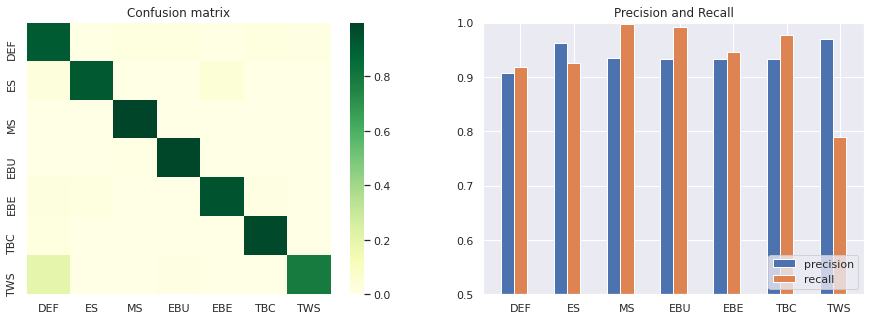

In [46]:
true = Y_val
pred = np.argmax(nn_model.predict(X_val),axis=1)
confusion_precision_recall(true,pred,class_dict)


Recall is high apart from the three white soldiers pattern. Precision is lower - ie  default cases are being incorrectly labelled. Lets look at some examples.


In [47]:
# false positive three black crows
class_TBC = class_dict['TBC']
idx_c = np.where((true==0)*(pred==class_TBC))
candles = X_val[idx_c[0][0],:,:]
plot_candles(candles,'Three black crows - false positive');

Clearly this looks a lot like a three black crows pattern - the reason it isn't is that the close on day one isn't close enough to the daily low. 


In [48]:
# false positive evening star
class_TBC = class_dict['ES']
idx_c = np.where((true==0)*(pred==class_TBC))
candles = X_val[idx_c[0][0],:,:]
plot_candles(candles,'Evening star - false positive');

In [49]:
# false negative three white soldiers
class_TWS = class_dict['TWS']
idx_tp = np.random.choice(np.where((true==class_TWS)*(pred==class_TWS))[0],4,replace=False)
idx_fn = np.random.choice(np.where((true==class_TWS)*(pred!=class_TWS))[0],4,replace=False)
for i,tp in enumerate(idx_tp): 
  candles = X_val[tp,:,:]
  plot_candles(candles,'Three White Soldiers - true positive');
for i,fn in enumerate(idx_fn): 
  candles = X_val[fn,:,:]
  plot_candles(candles,'Three White Soldiers - false negative');


  The criteria are met (3 white candles, successively higher highs, closing each day "near" the high) but the model fails to identify it.
     


In [50]:
def classify_timeseries_from_model(candles,model,max_pattern_size,rev_class_dict):
  # take a timeseries and find examples of different candlestick patterns
  if candles.shape[1] == 5:
    candles = candles[:,1:]

  annotation_list = []
  n_candles = candles.shape[0]
  for i in range(n_candles):
    if i < max_pattern_size-1:
      annotation_list.append('')
    else:
      this_candle = candles[i-max_pattern_size+1:i+1,:]
      this_candle=(this_candle-np.min(this_candle))/(np.max(this_candle)-np.min(this_candle))
      class_no = rev_class_dict[np.argmax(nn_model.predict(np.expand_dims(this_candle,axis=0)))]
      if class_no=='DEF':
        annotation_list.append('')
      else:
        annotation_list.append(class_no)
  return annotation_list

np.random.seed(1234)
candles = generate_candles(100, steps_per_day, open_step, close_step, daily_vol)
annotations_m = classify_timeseries_from_model(candles,nn_model,max_pattern_size,rev_class_dict)
annotations = classify_timeseries(candles,patterns_to_find,max_pattern_size,rev_functions_dict)
plot_candles(candles, title='Random daily candles with annotations', annotation_list=annotations);
plot_candles(candles, title='Random daily candles with nn model annotations', annotation_list=annotations_m);


Likewise we can do this with a real life time-series. For example here is the S&P 500 for the first 3 months of 2020.

In [51]:
spx = pd.read_csv('/content/data/SPXcandles.csv')
spx = spx.sort_index(ascending=False)
spx_candles = spx[['SPX Open','SPX High','SPX Low','SPX Close']].to_numpy()
dates = pd.to_datetime(spx['Date'],format='%d/%m/%Y')
spx_candles_q1 = spx_candles[dates.between('31/12/2019','31/03/2020').values,:]
annotation_list = classify_timeseries_from_model(spx_candles_q1,nn_model,3,rev_class_dict)
plot_candles(spx_candles_q1,'S&P 500 Q1 2020 with model detected classes',annotation_list);

# Decision trees and candlestick charts

Next I try  a gradient boosted decision tree. The rules for defining candlestick patterns invariably involve comparison of 2 prices - eg open(t) > close(t-1) 
or high(t) > high(t-1) or even body(t) > body(t-1) where of courses body(t) is just abs(open(t) - close(t)). Could a decision tree classifier recognise patterns from just features which are simply the differences between different prices? 

In [52]:
import itertools
import math

def generate_combinatorial_features(candles):
  n = candles.shape[-1]*candles.shape[-2]
  k = 2
  n_features = int(math.factorial(n)/(math.factorial(k)*math.factorial(n-k)))
  n_candles = candles.shape[0]
  features = np.zeros([n_candles,n_features])
  for i in range(n_candles):
    l = []
    [l.append(x) for x in candles[i,:,:].reshape([12,])]
    
    for j,comb in enumerate(itertools.combinations(l,k)):
      features[i,j] = comb[0] - comb[1]
  return features


This is hopelessly overfitted. The features we have generated are too general to derive any meaningful conclusions.   

In [53]:
fit_xgb_model = False
train_features = generate_combinatorial_features(X_train)
val_features = generate_combinatorial_features(X_val)
val_set = xgb.DMatrix(val_features,Y_val)

if fit_xgb_model:
  xgb_model = XGBClassifier(max_depth=5, n_estimators=10,min_child_weight = 1)
  xgb_model.fit(X=train_features,y=Y_train)
  pickle.dump(xgb_model, open("/content/data/model_xgb_.pickle.dat", "wb"))

else:
  xgb_model = pickle.load( open( "/content/data/model_xgb_.pickle.dat", "rb" ) )

xgb_pred_val = xgb_model.predict(val_features)
xgb_pred_train = xgb_model.predict(train_features)

val_accuracy = np.sum(xgb_pred_val == Y_val)/Y_val.shape[0]
train_accuracy = np.sum(xgb_pred_train == Y_train)/Y_train.shape[0]

print('Training accuracy = {:.4f}'.format(train_accuracy))
print('Validation accuracy = {:.4f}'.format(val_accuracy))



Training accuracy = 0.9788
Validation accuracy = 0.9783


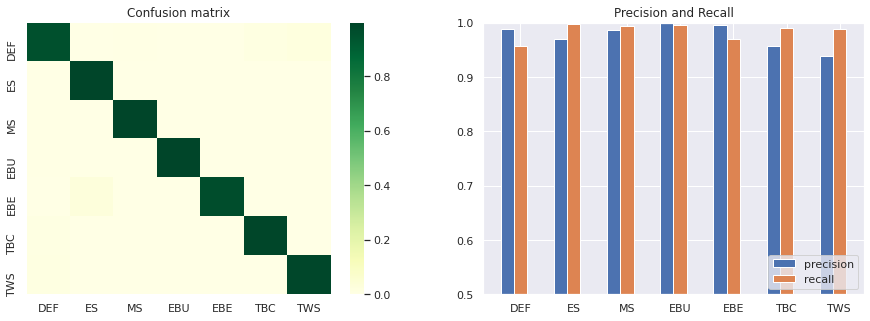

In [54]:
pred = xgb_pred_val
true = Y_val
confusion_precision_recall(true,pred,class_dict)


# Ensemble model and candlestick charts
Lets see if we can improve on this with better features. What if we try to train a gradient boosted decision tree on the output of the 2nd last layer of the neural network.

In [55]:
inp = nn_model.input                                           # input placeholder
outputs = [layer.output for layer in nn_model.layers]          # all layer outputs
functors = [K.function([inp], [out]) for out in outputs]    # evaluation functions

# Testing
layer_outs_train = [func([X_train]) for func in functors]
layer_outs_val = [func([X_val]) for func in functors]

cp_features_train = layer_outs_train[4][0]
cp_features_val = layer_outs_val[4][0]

val_set = xgb.DMatrix(cp_features_val,Y_val)
fit_ensemble_model = False
if fit_ensemble_model:
  xgb_model_ensemble = XGBClassifier(max_depth=10, n_estimators=100,min_child_weight = .1)
  xgb_model_ensemble.fit(X=cp_features_train,y=Y_train)

  xgb_pred_val = xgb_model_ensemble.predict(cp_features_val)
  xgb_pred_train = xgb_model_ensemble.predict(cp_features_train)

  # save model to file
  pickle.dump(xgb_model_ensemble, open("/content/data/model_xgb_ensemble.pickle.dat", "wb"))
else:
  xgb_model_ensemble = pickle.load( open( "/content/data/model_xgb_ensemble.pickle.dat", "rb" ) )

val_accuracy = np.sum(xgb_pred_val == Y_val)/Y_val.shape[0]
train_accuracy = np.sum(xgb_pred_train == Y_train)/Y_train.shape[0]
    
print('Training accuracy = {:.4f}'.format(train_accuracy))
print('Validation accuracy = {:.4f}'.format(val_accuracy))


Training accuracy = 0.9788
Validation accuracy = 0.9783


In [56]:
class ensemble_classifier:
  def __init__(self, nn_model, xgb_model):
    self.nn_model = nn_model
    self.xgb_model = xgb_model
  
  def predict(self, X):
    inp = nn_model.input                                        # input placeholder
    outputs = [layer.output for layer in nn_model.layers]          # all layer outputs
    functors = [K.function([inp], [out]) for out in outputs]    # evaluation functions

    layers_output = [func([X]) for func in functors]
    nn_outout_features = layers_output[-1][0] # the inputs to the 2nd layer are the features from the 2nd last layer of the neural net
    return self.xgb_model.predict(nn_outout_features)

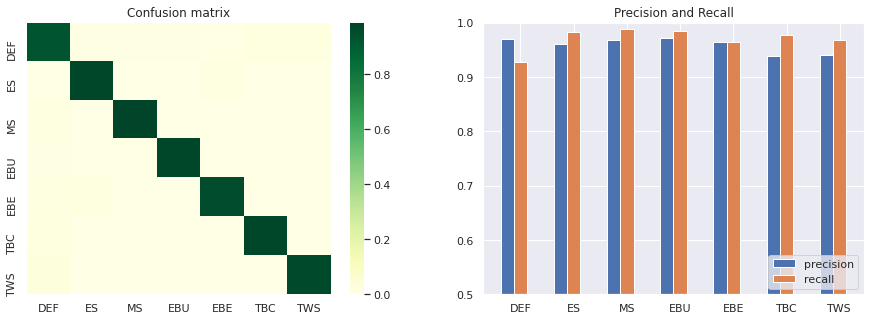

In [57]:
true = Y_val
ec = ensemble_classifier(nn_model=nn_model,xgb_model=xgb_model_ensemble)
pred = ec.predict(X_val)
confusion_precision_recall(true,pred,class_dict)


Lets see if the ensemble can identify patterns on which the neural network has not been trained.

In [58]:
X_train_full, X_val_full, Y_train_full, Y_val_full = train_test_split(X, Y, test_size=0.2, random_state=42)

#Y_train_full_oh = to_categorical(Y_train)
#Y_val_full_oh = to_categorical(Y_val)

inp = nn_model.input                                           # input placeholder
outputs = [layer.output for layer in nn_model.layers]          # all layer outputs
functors = [K.function([inp], [out]) for out in outputs]    # evaluation functions

# Testing
layer_outs_train = [func([X_train_full]) for func in functors]
layer_outs_val = [func([X_val_full]) for func in functors]

cp_features_train_full = layer_outs_train[4][0]
cp_features_val_full = layer_outs_val[4][0]

val_set = xgb.DMatrix(cp_features_val,Y_val_full)
fit_ensemble_model_full = False
if fit_ensemble_model_full:

  xgb_model_ensemble_full = XGBClassifier(max_depth=10, n_estimators=100,min_child_weight = .1)
  xgb_model_ensemble_full.fit(X=cp_features_train_full,y=Y_train_full)

  # save model to file
  pickle.dump(xgb_model_ensemble_full, open("/content/data/model_xgb_ensemble_full.pickle.dat", "wb"))

else:
  xgb_model_ensemble_full = pickle.load( open( "/content/data/model_xgb_ensemble_full.pickle.dat", "rb" ) )
  
xgb_pred_val_full = xgb_model_ensemble_full.predict(cp_features_val_full)
xgb_pred_train_full = xgb_model_ensemble_full.predict(cp_features_train_full)

val_accuracy = np.sum(xgb_pred_val_full == Y_val_full)/Y_val_full.shape[0]
train_accuracy = np.sum(xgb_pred_train_full == Y_train_full)/Y_train_full.shape[0]
    
print('Training accuracy = {:.4f}'.format(train_accuracy))
print('Validation accuracy = {:.4f}'.format(val_accuracy))

Training accuracy = 0.9829
Validation accuracy = 0.9382


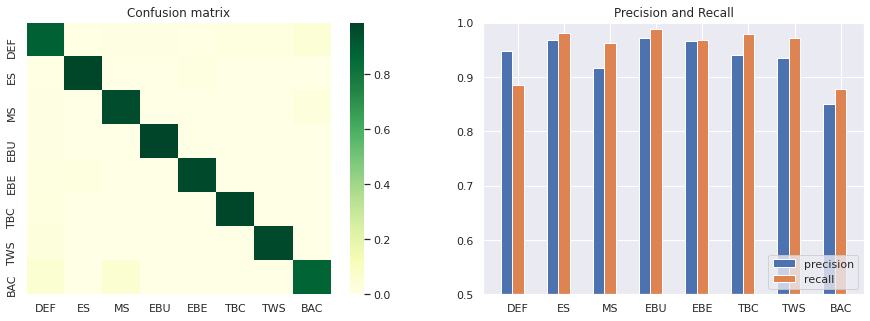

In [59]:
true = Y_val_full
ec = ensemble_classifier(nn_model=nn_model,xgb_model=xgb_model_ensemble_full)
pred = ec.predict(X_val_full)

confusion_precision_recall(true,pred,class_dict)

Clearly the classifier has trouble with the 'unseen' class. The features generated by the neural network model must bee specific to the classes it was trained on and in fact the simple combinatorial features are superior.

# Conclusion

The best candelstick pattern identifier is a gradient boosted decision tree fitted on combinatorial features. I will try to use these features to generate trading signals in another workbook